
# Fine Tuning



## Preparação dos Dados

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
caminho_arquivo = '/content/drive/MyDrive/JIS/anotações.csv'
df = pd.read_csv(caminho_arquivo)

In [ ]:
df.head()

,Frase,Categoria
0,ela é muito sensual,Aparência
1,menina bela,Aparência
2,você é diferente,Outro
3,ela é linda,Aparência
4,ela é guerreira,Caráter


In [ ]:
df.shape

(2000, 2)

In [ ]:
df = df[df['Categoria'].notna()]

In [ ]:
categoria_counts = df['Categoria'].value_counts()
print(categoria_counts)

Categoria
Papel Social    511
Caráter         491
Aparência       378
Outro           362
Emoção          258
Name: count, dtype: int64


In [ ]:
X = df['Frase'].values  # Frases
y = df['Categoria'].values  # Rótulos

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Categoria'])

In [ ]:
classes_mapeadas = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(classes_mapeadas)

{'Aparência': 0, 'Caráter': 1, 'Emoção': 2, 'Outro': 3, 'Papel Social': 4}


In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
def balance_classes(X, y):
    ros = RandomOverSampler(random_state=42)
    X, y = ros.fit_resample(X.reshape(-1, 1), y)
    return X.flatten(), y

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Treinamento

In [ ]:
# treinamento
def train_model(model, data_loader, optimizer):
    model = model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader)

## Avaliação

In [ ]:
# avaliação
from sklearn.metrics import classification_report

def evaluate_model(model, data_loader):
    model = model.eval()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            total_correct += torch.sum(preds == labels)
            total_samples += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Gera o classification report
    class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)

    return accuracy, precision, recall, f1, class_report, all_preds


In [ ]:
# tokenizer e o modelo BERTimbau
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased')
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-large-portuguese-cased', num_labels=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-large-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validação Cruzada Estratificada


In [ ]:
# Definir o número de folds para validação cruzada
n_splits = 10 #10 é o mais comum, mas pode aumentar o número de folds desde que contenha no minimo 30 exemplos em cada fold, ex: 100 exemplos anotados, deve ter no maximo 3 folds / Deve-se saber tbm, que quanto maior o número de folds, maior o custo computacional
skf = StratifiedKFold(n_splits=n_splits)

In [ ]:
# Otimizador
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
all_fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

In [ ]:
all_true_labels = []
all_pred_labels = []

## Treinamento e Avaliação de Modelo com Validação Cruzada Estratificada e Balanceamento de Classes

In [ ]:
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}/{n_splits}")

    # Dividir os dados em treino e teste
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Balancear as classes no conjunto de treino
    X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)

    # Criar datasets e dataloaders
    train_dataset = TextDataset(X_train_balanced, y_train_balanced, tokenizer)
    test_dataset = TextDataset(X_test, y_test, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # mini-batch de tamanho 16 e shuffle para pegar amostras aleatórias
    test_loader = DataLoader(test_dataset, batch_size=16) # mini-batch de tamanho 16

    # Treinar o modelo no fold atual
    train_loss = train_model(model, train_loader, optimizer)
    print(f"Loss de treino no Fold {fold+1}: {train_loss}") #quanto menor a loss em cada fold significa que o modelo está aprendendo

    # Avaliar o modelo no fold atual
    accuracy, precision, recall, f1, class_report, all_preds = evaluate_model(model, test_loader)
    #print(f"Acurácia no Fold {fold+1}: {accuracy}")
    #print(f"Precisão no Fold {fold+1}: {precision}")
    #print(f"Recall no Fold {fold+1}: {recall}")
    #print(f"F1-score no Fold {fold+1}: {f1}")
    #print(f"Classification Report no Fold {fold+1}:\n{class_report}")

    # Armazenar métricas para cada fold
    all_fold_metrics['accuracy'].append(accuracy)
    all_fold_metrics['precision'].append(precision)
    all_fold_metrics['recall'].append(recall)
    all_fold_metrics['f1'].append(f1)

    all_true_labels.extend(y_test)
    all_pred_labels.extend(all_preds)

# Cálculo das métricas finais (médias)
final_accuracy = np.mean(all_fold_metrics['accuracy'])
final_precision = np.mean(all_fold_metrics['precision'])
final_recall = np.mean(all_fold_metrics['recall'])
final_f1 = np.mean(all_fold_metrics['f1'])


print(f"\nDesempenho Final:")
print(f"Accuracy Média: {final_accuracy}")
print(f"Precision Média: {final_precision}")
print(f"Recall Médio: {final_recall}")
print(f"F1-score Médio: {final_f1}")

# Geração do Classification Report geral
final_class_report = classification_report(all_true_labels, all_pred_labels, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(final_class_report)

Fold 1/10
Loss de treino no Fold 1: 1.1073683233310778
Fold 2/10
Loss de treino no Fold 2: 0.5760200564335618
Fold 3/10
Loss de treino no Fold 3: 0.3685097669561704
Fold 4/10
Loss de treino no Fold 4: 0.2787858087362515
Fold 5/10
Loss de treino no Fold 5: 0.20367698235592493
Fold 6/10
Loss de treino no Fold 6: 0.14910688943281356
Fold 7/10
Loss de treino no Fold 7: 0.1328776816953905
Fold 8/10
Loss de treino no Fold 8: 0.11182666380449922
Fold 9/10
Loss de treino no Fold 9: 0.08223522872625229
Fold 10/10
Loss de treino no Fold 10: 0.07669267475850777

Desempenho Final:
Accuracy Média: 0.915
Precision Média: 0.9194995034104341
Recall Médio: 0.915
F1-score Médio: 0.9136761386511371

Classification Report:
              precision    recall  f1-score   support

   Aparência       0.92      0.93      0.93       378
     Caráter       0.89      0.89      0.89       491
      Emoção       0.92      0.96      0.94       258
       Outro       0.89      0.84      0.86       362
Papel Social    

In [ ]:
!mkdir model
model.save_pretrained("./model")
tokenizer.save_pretrained("./model")

!zip -r /content/model.zip /content/model

from google.colab import files
files.download("/content/model.zip")

  adding: content/model/ (stored 0%)
  adding: content/model/special_tokens_map.json (deflated 42%)
  adding: content/model/tokenizer_config.json (deflated 74%)
  adding: content/model/config.json (deflated 56%)
  adding: content/model/model.safetensors (deflated 7%)
  adding: content/model/vocab.txt (deflated 52%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Feminino

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Remount with force_remount=True

Mounted at /content/drive


In [ ]:
caminho_arquivo1 = '/content/drive/MyDrive/JIS/df sem duplicatas.csv'
df1 = pd.read_csv(caminho_arquivo1)

In [ ]:
df1.shape

(15223, 7)

In [ ]:
df1.head()

,Padrão,Frase,Nome da Música,Artista,Gênero Musical,Letra da Música
0,sujeito_aux_adv_adj,ela é muito sensual,Carolina,Seu Jorge,MPB,Carolina é uma menina bem difícil de esquecer ...
1,sujeito_adj,menina bela,Carolina,Seu Jorge,MPB,Carolina é uma menina bem difícil de esquecer ...
2,pronoun+aux+adj,você é diferente,Tarde Vazia (feat. Samuel Rosa) - Versão Acústica,Ira!,Rock,"Pela janela vejo fumaça, vejo pessoas Na rua o..."
3,sujeito_aux_adj,ela é linda,Rodo cotidiano,O Rappa,Rock,Ô ô ô ô ô my brother Ô ô ô ô ô my brother Ô ô ...
4,sujeito_aux_adj,ela é guerreira,Ela Vai Voltar (Todos Os Defeitos De Uma Mulhe...,Charlie Brown Jr.,Rock,"Minha mente, nem sempre tão lúcida É fértil e ..."


In [ ]:
sentencas = df1['Frase'].tolist()

In [ ]:
batch_size = 16
predicoes_finais = []
model = model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
# mini batch
for i in range(0, len(sentencas), batch_size):
    sentencas_lote = sentencas[i:i+batch_size]

    tokens = tokenizer(
        sentencas_lote,
        padding=True,
        truncation=True,
        max_length=128,  # Mesmo max_length usado no treino
        return_tensors="pt"
    )

    tokens = {key: val.to(device) for key, val in tokens.items()}

    with torch.no_grad():
        outputs = model(**tokens)

    # Obter as previsões (softmax -> argmax para pegar a classe mais provável)
    pred_classes = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Mover para a CPU pq tava dando estouro de GPU

    predicoes_finais.extend(pred_classes)

In [ ]:
df1['Categoria'] = predicoes_finais

df1['Categoria'] = df1['Categoria'].map({0: 'Aparência', 1: 'Caráter', 2: 'Emoção', 3: 'Outro', 4: 'Papel Social'}) #{'Aparência': 0, 'Caráter': 1, 'Emoção': 2, 'Outro': 3, 'Papel Social': 4}


In [ ]:
from google.colab import files

df1.to_csv('df1_com_previsoes.csv', index=False)
files.download('df1_com_previsoes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
categoria_counts_df1 = df1['Categoria'].value_counts()
print(categoria_counts_df1)

Categoria
Outro           4343
Aparência       4175
Caráter         3223
Papel Social    2550
Emoção           932
Name: count, dtype: int64


# Masculino

In [ ]:
caminho_arquivo2 = '/content/drive/MyDrive/JIS/df masculino sem duplicata.csv'
df2 = pd.read_csv(caminho_arquivo2)

In [ ]:
df2.shape

(15081, 7)

In [ ]:
df2.head()

,Padrão,Frase,Nome da Música,Artista,Gênero Musical,Letra da Música
0,nome_NOUN,caro pai,Lugar Ao Sol,Charlie Brown Jr.,Rock,"Que bom viver, como é bom sonhar E o que ficou..."
1,pronoun_aposto_adjetivo_noun_det,"você, o mar","Eu, Você, O Mar e Ela",Luan Santana,Sertanejo,Ser romântico às vezes ajuda Mas se fecho os o...
2,nome_aux_NOUN,cês são padre,Balão,Orochi,Trap,"Dallass, yo Bom dia pra você e pra todos que e..."
3,nome_NOUN,meto marcha,Deus é por nós,MC Marks,Funk,"(Ai, ai, ai, ai, ai) (Ai, ai, ai, ai, ai) (É o..."
4,sujeito_NOUN,namorado ficar,Meu Pedaço de Pecado,João Gomes,Forró,Meu pedaço de pecado De corpo colado Vem dança...


In [ ]:
sentencasMasc = df2['Frase'].tolist()

In [ ]:
batch_size = 16

predicoes_finais2 = []

model = model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
# mini batch
for i in range(0, len(sentencasMasc), batch_size):
    sentencas2_lote = sentencasMasc[i:i+batch_size]

    tokens = tokenizer(
        sentencas2_lote,
        padding=True,
        truncation=True,
        max_length=128,  # Mesmo max_length usado no treino
        return_tensors="pt"
    )

    tokens = {key: val.to(device) for key, val in tokens.items()}

    with torch.no_grad():
        outputs2 = model(**tokens)

    # Obter as previsões (softmax -> argmax para pegar a classe mais provável)
    pred_classes2 = torch.argmax(outputs2.logits, dim=1).cpu().numpy()  # Mover para a CPU pq tava dando estouro de GPU

    predicoes_finais2.extend(pred_classes2)

In [ ]:
df2['Categoria'] = predicoes_finais2

df2['Categoria'] = df2['Categoria'].map({0: 'Aparência', 1: 'Caráter', 2: 'Emoção', 3: 'Outro', 4: 'Papel Social'}) #{'Aparência': 0, 'Caráter': 1, 'Emoção': 2, 'Outro': 3, 'Papel Social': 4}

In [ ]:
from google.colab import files

df2.to_csv('df2_com_previsoes.csv', index=False)
files.download('df2_com_previsoes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
categoria_counts_df2 = df2['Categoria'].value_counts()
print(categoria_counts_df2)

Categoria
Outro           5443
Papel Social    3637
Caráter         3165
Aparência       1848
Emoção           988
Name: count, dtype: int64


# Gráfico

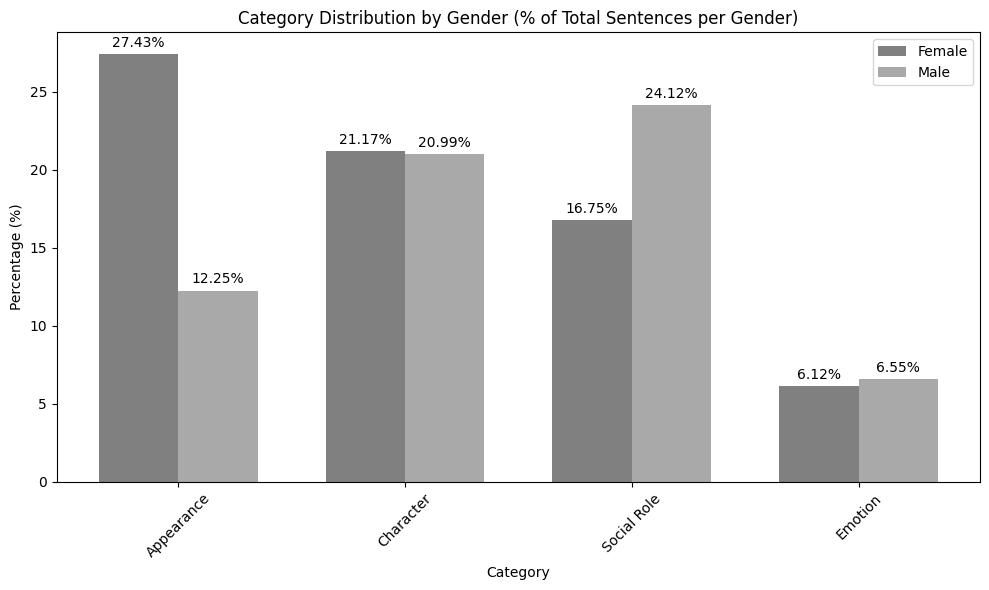

In [ ]:
import matplotlib.pyplot as plt

categorias = ['Appearance', 'Character', 'Social Role', 'Emotion']
valores_male = [1848, 3165, 3637, 988]
valores_female = [4175, 3223, 2550, 932]

total_male = 15081
total_female = 15223

percentuais_male = [round((v / total_male) * 100, 2) for v in valores_male]
percentuais_female = [round((v / total_female) * 100, 2) for v in valores_female]

x = range(len(categorias))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects_f = ax.bar([i - width/2 for i in x], percentuais_female, width, label='Female', color='grey')
rects_m = ax.bar([i + width/2 for i in x], percentuais_male, width, label='Male', color='darkgrey')

ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Category')
ax.set_title('Category Distribution by Gender (% of Total Sentences per Gender)')
ax.set_xticks(x)
ax.set_xticklabels(categorias, rotation=45)
ax.legend()

def autolabel(rects, valores):
    for rect, val in zip(rects, valores):
        ax.annotate(f'{val}%',
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects_f, percentuais_female)
autolabel(rects_m, percentuais_male)

plt.tight_layout()
plt.show()
